# LMP

In [2]:
import pandas as pd
import numpy as np
import sys, os, warnings
sys.path.insert(0, '../../../../../FISH-annotation/fishanno')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

from starfish import data, FieldOfView
from starfish.image import Filter
from starfish.spots import DetectSpots
from starfish.types import Axes

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from skimage.io import imread

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [3]:
test_img_filename = 'ISS_rnd1_ch1_z0'

round_ind = 1
channel_ind = 1

origins = ['expert', 'consensus']
correctness_threshold = 10
stringencies = range(3)

In [4]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.ISS(use_test_data=use_test_data)
fov = experiment.fov()
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)

100%|██████████| 16/16 [00:00<00:00, 18.50it/s]


In [5]:
# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered_imgs = filt.run(imgs, verbose=True, in_place=False)

16it [00:20,  2.23s/it]


In [6]:
if not os.path.exists('./blobs_lmp_1_1/'):
    os.mkdir('./blobs_lmp_1_1/')

In [7]:
for stringency in stringencies:

    print(stringency)

    test_img_path = './test_images_filtered/images/%s.png' % test_img_filename
    im = imread(test_img_path, as_gray=True)
    img_height = len(im)

    # slice the ImageStack
    sel={Axes.ROUND: round_ind, Axes.CH: channel_ind, Axes.ZPLANE: 0}
    single_plane_filtered = filtered_imgs.sel(sel)

    lmp = DetectSpots.LocalMaxPeakFinder(
        min_distance=6,
        stringency=stringency,
        min_obj_area=6,
        max_obj_area=600,
    )

    new_stack = single_plane_filtered.from_numpy(single_plane_filtered.xarray.values) 
    intensities = lmp.run(new_stack)
    spots = intensities[:, 0, 0].where(intensities[:, 0, 0] != 0, drop=True)
    x_vals = spots.x.values
    y_vals = spots.y.values

    blobs = []
    for x, y in zip(x_vals, y_vals):
        blobs.append([x, y])
    blobs = np.asarray(blobs)

    path = './blobs_lmp/%s_%s.csv' % (test_img_filename, stringency)
    np.savetxt(path, blobs, delimiter=",")


0


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 92%|█████████▏| 92/100 [00:20<00:03,  2.61it/s]

Stopping early at threshold=0.20484574515410142. Number of spots fell below: 3
computing final spots ...


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 92%|█████████▏| 92/100 [00:16<00:01,  5.75it/s]

Stopping early at threshold=0.20484574515410142. Number of spots fell below: 3
computing final spots ...


  0%|          | 0/1 [00:00<?, ?it/s]

2


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 92%|█████████▏| 92/100 [00:16<00:01,  5.29it/s]

Stopping early at threshold=0.20484574515410142. Number of spots fell below: 3
computing final spots ...


In [8]:
precision_recall = []
expert_path = './test_images_filtered/coords/%s.csv' % test_img_filename
consensus_path = './consensus/%s/total.csv' % test_img_filename

for stringency in stringencies:
    print(stringency)
    for origin in origins:

        ref_path = expert_path if origin=='expert' else consensus_path
        ref_coords = np.asarray(pd.read_csv(ref_path))  

        print(ref_path)

        # calc precision and recall
        precision, recall = util.get_precision_recall(test_coords=blobs, ref_coords=ref_coords, correctness_threshold=correctness_threshold)
        precision_recall.append((precision, recall))

        blobs = np.asarray(pd.read_csv('./blobs_lmp_4/%s_%s.csv' % (test_img_filename, stringency), header=None))

        print(precision, recall)
#         ####################
#         plt.figure(figsize=(10,10))
#         for x, y in blobs:
#             plt.scatter([x], [y], edgecolor='cyan', facecolor='None')
#         plt.imshow(im, cmap='gray')
#         for x, y in ref_coords:
#             plt.scatter([x], [y], edgecolor='yellow', facecolor='None')
#         plt.title('Stringency = %s. Precision = %s, Recall = %s based on %s annotations' % (stringency, round(precision, 2), round(recall, 2), origin))
#         plt.show()
#         ###################
np.savetxt('./blobs_lmp/precision_recall.csv', precision_recall, delimiter=",")

0
./test_images_filtered/coords/ISS_rnd1_ch1_z0.csv
0.3444394416929311 0.89198606271777
./consensus/ISS_rnd1_ch1_z0/total.csv
0.14648729446935724 0.6051873198847262
1
./test_images_filtered/coords/ISS_rnd1_ch1_z0.csv
0.16018933731938217 0.6376306620209059
./consensus/ISS_rnd1_ch1_z0/total.csv
0.14518555667001004 0.579250720461095
2
./test_images_filtered/coords/ISS_rnd1_ch1_z0.csv
0.15897693079237712 0.6132404181184669
./consensus/ISS_rnd1_ch1_z0/total.csv
0.14573248407643313 0.553314121037464


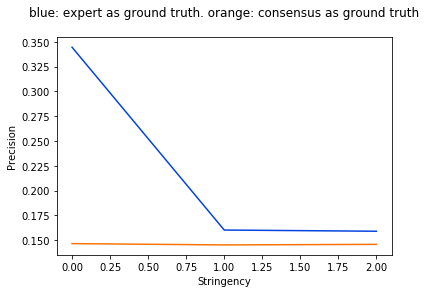

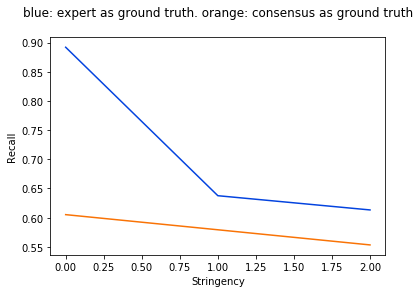

In [9]:
precision_recall = np.asarray(pd.read_csv('./blobs_lmp/precision_recall.csv', header=None))
expert_precision_recall, consensus_precision_recall = [], []
for ind, pr in enumerate(precision_recall):
    p, r = pr
    if ind % 2 == 0:
        expert_precision_recall.append([p,r])
    else:
        consensus_precision_recall.append([p,r])
plt.figure()
plt.title('blue: expert as ground truth. orange: consensus as ground truth\n')
plt.plot(stringencies, [x[0] for x in expert_precision_recall], c='xkcd:blue')
plt.plot(stringencies, [x[0] for x in consensus_precision_recall], c='xkcd:orange')
plt.xlabel('Stringency')
plt.ylabel('Precision')
plt.show()

plt.figure()
plt.title('blue: expert as ground truth. orange: consensus as ground truth\n')
plt.plot(stringencies, [x[1] for x in expert_precision_recall], c='xkcd:blue')
plt.plot(stringencies, [x[1] for x in consensus_precision_recall], c='xkcd:orange')
plt.xlabel('Stringency')
plt.ylabel('Recall')
plt.show()

In [10]:
expert_precision = expert_precision_recall[0][0]
consensus_precision = consensus_precision_recall[0][0]
expert_recall = expert_precision_recall[0][1]
consensus_recall = consensus_precision_recall[0][1]
expert_precision, consensus_precision, expert_recall, consensus_recall

(0.34443944169293117,
 0.14648729446935724,
 0.89198606271777,
 0.6051873198847261)